## fundemental of pyvisa

In [1]:
import pyvisa

rm = pyvisa.ResourceManager()
List = rm.list_resources() # read instruments by GPIB
Inst_l = []
Instname_l = []
for resource in List:
    inst = rm.open_resource(resource)
    print(resource)
    print(inst.query("*IDN?")) # send query for name of instrument
    
    Inst_l.append(inst)
    Instname_l.append(inst.query("*IDN?"))

GPIB0::1::INSTR
ADC Corp.,R6240A,040300114,B00  

GPIB0::6::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2182A,1300416,C02  /A02  

GPIB0::16::INSTR
Agilent Technologies,N5222A,MY51421769,A.10.00.00

GPIB0::19::INSTR
Agilent Technologies, N5183A, MY50142013, A.01.87



In [38]:
import pyvisa
rm = pyvisa.ResourceManager()
List = rm.list_resources() # read instruments by GPIB
List

()

## with pymeasure

In [ ]:
from pymeasure.instruments import list_resources
list_resources()

In [4]:
from pymeasure.instruments.keithley import Keithley2000
multimeter = Keithley2000("GPIB::14")
multimeter.measure_voltage()

print(multimeter.voltage)

0.0828554344


In [5]:
from pymeasure.instruments.adcmt import Adcmt6240A
import time
source = Adcmt6240A("GPIB::01")
source.initialize()
source.source_enabled(enable=True)
for i in range(0,10):
    source_voltage = i*10**-3
    source.apply_voltage(source_voltage=source_voltage)
    time.sleep(0.5)
source.source_enabled(enable=False)
source.shutdown()




In [6]:
source.voltage = 1

LookupError: Instrument property can not be set.

In [3]:
from pymeasure.instruments.keithley import Keithley2000
multimeter = Keithley2000("GPIB::14")
multimeter.measure_voltage()

print(multimeter.voltage)

NameError: name 'Keithley2000' is not defined

In [ ]:
# multimeter.enable_filter(type="repeat",count=10)
multimeter.auto_range()

In [ ]:
multimeter.voltage

## ADCMT

In [22]:
ADCMT = rm.open_resource('GPIB::01')
#電源の電圧を計測
# max_volt = ADCMT.query('MEAS:VOLT?')

# queryを使わない方法
ADCMT.write('SOV 0.001')
# max_volt = ADCMT.read()

11

In [15]:
from pymeasure.instruments.adcmt import Adcmt6240A
testADCMT = Adcmt6240A('GPIB::1')

ImportError: cannot import name 'Adcmt6240A' from 'pymeasure.instruments.adcmt' (c:\Users\Ando_lab\anaconda3\envs\pymeasure_env\lib\site-packages\pymeasure\instruments\adcmt\__init__.py)

In [23]:
ADCMT.write('*RST')
ADCMT.write('VF')
ADCMT.write('SOV0.001,LMI0.003')
ADCMT.write('*RST')

6

In [20]:
ADCMT.write("NZ0")

5

## Kethley2182A

In [12]:
nanovol = rm.open_resource('GPIB::6')

#電源の電圧を計測
# max_volt = ADCMT.query('MEAS:VOLT?')

# queryを使わない方法
nanovol.write('*RST')
nanovol.write(":SENSe:FUNCtion 'VOLTage:DC'")

nanovol.write(":SENS:FUNC 'VOLT'")
#keithley2182A.write("*RST")
nanovol.write(":DISPlay:ENABle ON")
nanovol.write(":SENSe:VOLTage:NPLCycles 1") # medium
nanovol.write(":SENSe:VOLTage:DFILter 0") # digital filter off
for i in range(0,5):
    nanovol.write(":READ?")
    print(float(nanovol.read()))

0.00114061678
-0.000531545507
-0.00209423605
-0.00367416321
-0.00539273191


In [14]:
from pymeasure.instruments.keithley import Keithley2182A
nanovol_py = Keithley2182A("GPIB::6")
nanovol_py.set_filter(WIND=0)
nanovol_py.set_rate(PLC=1)
for i in range(0,5):
    print(nanovol_py.measure_voltage())

-0.0495202727
-0.0527710231
-0.0559292786
-0.0588985668
-0.0618204539


## AgilentN5183A

In [6]:
from pymeasure.instruments.agilent import AgilentN5183A
signalgenerator = AgilentN5183A('GPIB0::19')
signalgenerator.initialize()
signalgenerator.set_config()
signalgenerator.set_frequency(1)
signalgenerator.set_power(0)
signalgenerator.source_enabled(True)
signalgenerator.source_enabled(False)
signalgenerator.shutdown()

## Keithley2450A

In [12]:
from pymeasure.instruments.keithley import Keithley2450
keithley = Keithley2450("GPIB::18")
keithley.apply_voltage()                # Sets up to source voltage
keithley.source_voltage_range = 1  # Sets the source voltage range to 1
keithley.compliance_current = 0.01        # Sets the compliance current to 0.01A
keithley.source_voltage = 0        # Sets the source current to 0 V
keithley.enable_source() 
keithley.measure_voltage()              # Sets up to measure voltage

keithley.ramp_to_voltage(0.1)          # Ramps the voltage to 0.1 V
print(keithley.voltage)    

0.1000073


In [21]:
keithley.disable_source()


In [14]:
keithley.enable_source() 


In [20]:
#二行目でモニターには反映されてるけど、多分一行目だけで出力はしてる
keithley.source_voltage = -0.3
keithley.voltage

-0.2999713

## Agilent N5222A

In [1]:
import pyvisa

rm = pyvisa.ResourceManager()
List = rm.list_resources() # read instruments by GPIB
Inst_l = []
Instname_l = []
for resource in List:
    inst = rm.open_resource(resource)
    print(resource)
    print(inst.query("*IDN?")) # send query for name of instrument
    
    Inst_l.append(inst)
    Instname_l.append(inst.query("*IDN?"))

GPIB0::1::INSTR
ADC Corp.,R6240A,040300114,B00  

GPIB0::6::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2182A,1300416,C02  /A02  

GPIB0::16::INSTR
Agilent Technologies,N5222A,MY51421769,A.10.00.00

GPIB0::19::INSTR
Agilent Technologies, N5183A, MY50142013, A.01.87



In [2]:
netana = rm.open_resource('GPIB::16')

In [3]:
netana.write("SYST:FPRESET")

14

In [4]:
netana.write("DISPlay:WINDow1:STATE ON")#netana上のいつものグラフのウィンドウができる

26

In [5]:
def SendAna(str):
    return netana.write(str)

### 完成 frequencies dependence of S parameters

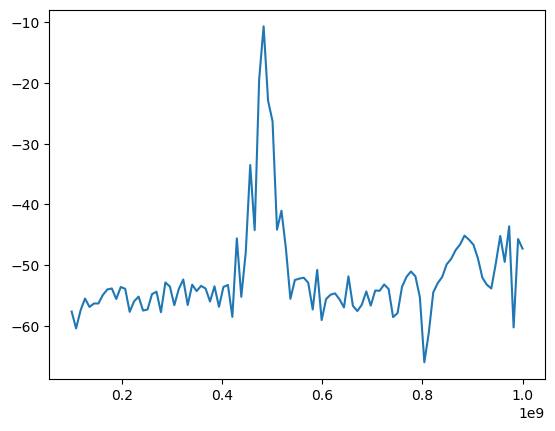

In [238]:
import time
SendAna("SYST:FPReset") # preset

SendAna("DISPlay:WINDow1:STATE ON")#turn on display
SendAna("CALCulate1:PARameter:DEFine:EXT 'MyMeas1',S21")#Define masurement name and parameters
SendAna("DISPlay:WINDow1:TRACe1:FEED 'MyMeas1'")#shows graph result in window
# SendAna("CALC:PAR:SEL 'MyMeas1'")


SendAna("SENS1:SWE:TYPE 'LIN'")#sweep type
SendAna("SENS1:FREQ:STAR 1e8")#Start of frequency
SendAna("SENS1:FREQ:STOP 1e9")#End of frequency
SendAna("SENS1:SWE:POIN 102")#Numebr of sweep points
SendAna("SOUR:POW1 5") #power DB
SendAna("SENSe1:BWID 1kHZ")#band width


SendAna("DISP:WIND1:TRAC:Y:SCAL:AUTO") # Auto y scale of display 

SendAna("SENS1:AVER:CLE")#Clear average
SendAna("SENS1:AVER:COUN 2")#1-2^16
SendAna("SENS1:AVER ON")
# SendAna("TRIG:SOUR Man")#Trigger set manual

time.sleep(1)

# SendAna("SENS1:SWE:TIME:AUTO ON")#Auto
SendAna("SENS1:SWE:TIME 0.1")#seconds
# SendAna("SENS:FREQ 1e9")#CW
netana.query("SENS1:SWE:TIME?")
# SendAna("TRIG:CHAN1:AUX:DEL 0")#Aux trigger


SendAna("SENS1:X?") #get X values(ex:frequency)

SendAna("CALC1:PAR:CAT?") #->'"MyMeas1,S21"\n'
SendAna("CALC1:PAR:SEL 'MyMeas1'") #set data name
SendAna("FORM:DATA 'ASCII'")# set data format
SendAna("FORM:BORD")#
time.sleep(1)

# SendAna("CALC1:DATA?")
X = netana.query("SENS1:X?") # get x data
Y = netana.query("CALC1:DATA? SDATA")# get complex data

import matplotlib.pyplot as plt
import numpy as np
import cmath

x = list(map(float, X.split(",")))#x data
y0 = list(map(float, Y.split(",")))[0::2] #real part
y1 = list(map(float, Y.split(",")))[1::2] #imaginary part

y = [x+y*1j for x, y in  zip(y0,y1)] # make complex value from Re and Im
r = np.array(list(map(abs,y)))#get absolute values
theta = np.array(list(map(cmath.phase,y)))#get phases
# print(theta)
R = 10*np.log10(r**2)# R mW -> dbm
plt.plot(x, R)
#plt.yscale("log")

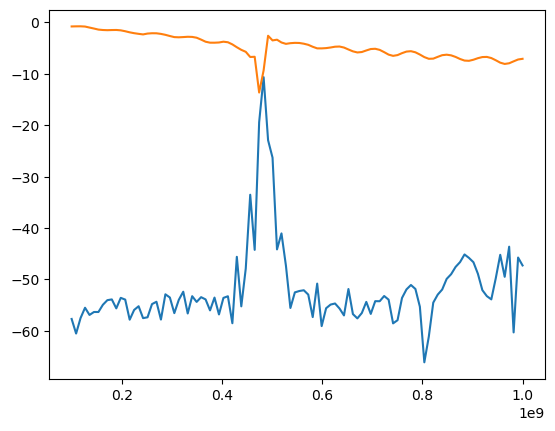

In [241]:
import time
SendAna("SYST:FPReset") # preset

SendAna("DISPlay:WINDow1:STATE ON")#turn on display
SendAna("CALCulate1:PARameter:DEFine:EXT 'MyMeas1',S21")#Define masurement name and parameters
SendAna("DISPlay:WINDow1:TRACe1:FEED 'MyMeas1'")#shows graph result in window
# SendAna("CALC:PAR:SEL 'MyMeas1'")

SendAna("DISPlay:WINDow2:STATE ON")#turn on display
SendAna("CALCulate2:PARameter:DEFine:EXT 'MyMeas2',S11")#Define masurement name and parameters
SendAna("DISPlay:WINDow2:TRACe2:FEED 'MyMeas2'")#shows graph result in window
# SendAna("CALC:PAR:SEL 'MyMeas1'")


SendAna("SENS1:SWE:TYPE 'LIN'")#sweep type
SendAna("SENS1:FREQ:STAR 1e8")#Start of frequency
SendAna("SENS1:FREQ:STOP 1e9")#End of frequency
SendAna("SENS1:SWE:POIN 102")#Numebr of sweep points
SendAna("SOUR:POW1 5") #power DB
SendAna("SENSe1:BWID 1kHZ")#band width


SendAna("SENS2:SWE:TYPE 'LIN'")#sweep type
SendAna("SENS2:FREQ:STAR 1e8")#Start of frequency
SendAna("SENS2:FREQ:STOP 1e9")#End of frequency
SendAna("SENS2:SWE:POIN 102")#Numebr of sweep points
SendAna("SOUR:POW2 5") #power DB
SendAna("SENSe2:BWID 1kHZ")#band width


SendAna("DISP:WIND1:TRAC:Y:SCAL:AUTO") # Auto y scale of display 
SendAna("DISP:WIND2:TRAC:Y:SCAL:AUTO") # Auto y scale of display 

SendAna("SENS1:AVER:CLE")#Clear average
SendAna("SENS1:AVER:COUN 2")#1-2^16
SendAna("SENS1:AVER ON")
# SendAna("TRIG:SOUR Man")#Trigger set manual


SendAna("SENS2:AVER:CLE")#Clear average
SendAna("SENS2:AVER:COUN 2")#1-2^16
SendAna("SENS2:AVER ON")
# SendAna("TRIG:SOUR Man")#Trigger set manual

time.sleep(1)

# SendAna("SENS1:SWE:TIME:AUTO ON")#Auto
SendAna("SENS1:SWE:TIME 0.1")#seconds

SendAna("SENS2:SWE:TIME 0.1")#seconds

# SendAna("SENS:FREQ 1e9")#CW
netana.query("SENS1:SWE:TIME?")
# SendAna("TRIG:CHAN1:AUX:DEL 0")#Aux trigger


SendAna("SENS1:X?") #get X values(ex:frequency)
SendAna("SENS2:X?") #get X values(ex:frequency)


SendAna("CALC1:PAR:CAT?") #->'"MyMeas1,S21"\n'
SendAna("CALC1:PAR:SEL 'MyMeas1'") #set data name

SendAna("CALC2:PAR:CAT?") #->'"MyMeas1,S21"\n'
SendAna("CALC2:PAR:SEL 'MyMeas2'") #set data name

SendAna("FORM:DATA 'ASCII'")# set data format
SendAna("FORM:BORD")#
time.sleep(1)

# SendAna("CALC1:DATA?")
X = netana.query("SENS1:X?") # get x data
Y = netana.query("CALC1:DATA? SDATA")# get complex data
X2 = netana.query("SENS2:X?") # get x data
Y2 = netana.query("CALC2:DATA? SDATA")# get complex data

import matplotlib.pyplot as plt
import numpy as np
import cmath

x = list(map(float, X.split(",")))#x data
y0 = list(map(float, Y.split(",")))[0::2] #real part
y1 = list(map(float, Y.split(",")))[1::2] #imaginary part

y = [x+y*1j for x, y in  zip(y0,y1)] # make complex value from Re and Im
r = np.array(list(map(abs,y)))#get absolute values
theta = np.array(list(map(cmath.phase,y)))#get phases
# print(theta)
R = 10*np.log10(r**2)# R mW -> dbm

x2 = list(map(float, X2.split(",")))#x data
y02 = list(map(float, Y2.split(",")))[0::2] #real part
y12 = list(map(float, Y2.split(",")))[1::2] #imaginary part

y2 = [x+y*1j for x, y in  zip(y02,y12)] # make complex value from Re and Im
r2 = np.array(list(map(abs,y2)))#get absolute values
theta2 = np.array(list(map(cmath.phase,y2)))#get phases
# print(theta)
R2 = 10*np.log10(r2**2)# R mW -> dbm

plt.plot(x, R)
plt.plot(x2, R2)
#plt.yscale("log")

### CW

In [330]:
import time
SendAna("SYST:FPReset") # preset

SendAna("DISPlay:WINDow1:STATE ON")#turn on display
SendAna("CALCulate1:PARameter:DEFine:EXT 'MyMeas1',S21")#Define masurement name and parameters
SendAna("DISPlay:WINDow1:TRACe1:FEED 'MyMeas1'")#shows graph result in window
# SendAna("CALC:PAR:SEL 'MyMeas1'")



39

In [331]:

SendAna("SENS1:SWE:TYPE CW")#sweep type continuous wave
SendAna("SENS1:FREQ:CW 1e9")#CW
SendAna("SENS1:SWE:TIME 1")#seconds

# SendAna("SENS1:FREQ:STAR 1e8")#Start of frequency
# SendAna("SENS1:FREQ:STOP 1e9")#End of frequency
SendAna("SENS1:SWE:POIN 1000")#Numebr of sweep points
SendAna("SOUR:POW1 5") #power DB
SendAna("SENSe1:BWID 1kHZ")#band width

# time.sleep(1)

SendAna("DISP:WIND1:TRAC:Y:SCAL:AUTO") # Auto y scale of display 

SendAna("SENS1:AVER:CLE")#Clear average
SendAna("SENS1:AVER:COUN 100")#1-2^16
SendAna("SENS1:AVER ON")
# SendAna("TRIG:SOUR Man")#Trigger set manual


15

In [332]:

time.sleep(5)
print("start")

SendAna("TRIG:SOUR Man")#Auto
SendAna("SENS1:SWE:TIME:AUTO 2")#seconds
SendAna("SENS1:SWE:MODE SING")
# # netana.query("SENS1:SWE:TIME?")
# # SendAna("TRIG:CHAN1:AUX:DEL 0")#Aux trigger

# SendAna("INIT:IMM")#ON?
# SendAna("DISP:WIND1:TRAC:Y:SCAL:AUTO") # Auto y scale of display 
time.sleep(10)


start


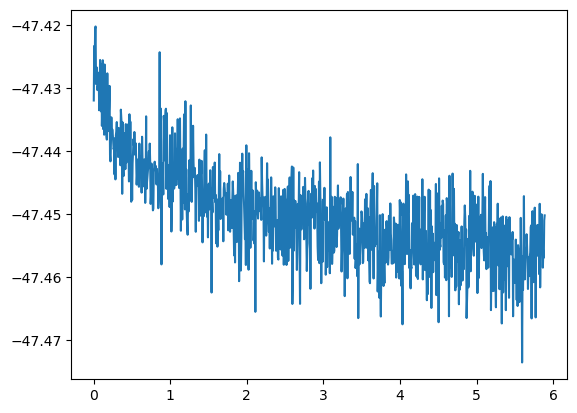

In [333]:

SendAna("SENS1:X?") #get X values(ex:frequency)

SendAna("CALC1:PAR:CAT?") #->'"MyMeas1,S21"\n'
SendAna("CALC1:PAR:SEL 'MyMeas1'") #set data name
SendAna("FORM:DATA 'ASCII'")# set data format
SendAna("FORM:BORD")#
time.sleep(1)

# SendAna("CALC1:DATA?")
X = netana.query("SENS1:X?") # get x data
Y = netana.query("CALC1:DATA? SDATA")# get complex data

import matplotlib.pyplot as plt
import numpy as np
import cmath

x = list(map(float, X.split(",")))#x data
y0 = list(map(float, Y.split(",")))[0::2] #real part
y1 = list(map(float, Y.split(",")))[1::2] #imaginary part

y = [x+y*1j for x, y in  zip(y0,y1)] # make complex value from Re and Im
r = np.array(list(map(abs,y)))#get absolute values
theta = np.array(list(map(cmath.phase,y)))#get phases
# print(theta)
R = 10*np.log10(r**2)# R mW -> dbm
plt.plot(x, R)
#plt.yscale("log")

In [334]:
SendAna("INIT:IMM")#Stop all sweep

10

In [335]:
# SendAna("SOUR:POW1:MODE OFF")
SendAna("OUTP OFF")


10

In [8]:
SendAna("DISPlay:WINDow1:TRACe1:FEED 'MyMeas'")

In [30]:
SendAna("SENS:FREQ:START 1e9")
SendAna("SENS:FREQ:END 2e9")
SendAna("SENS:FOM:RANG3:FREQ:OFFS 1e9")
SendAna("SENS:OFFS ON")

### 完成

In [237]:
SendAna("SYST:FPReset")
SendAna("DISPlay:WINDow1:STATE ON")
SendAna("DISPlay:WINDow2:STATE ON")

SendAna("CALCulate1:PARameter:DEFine 'MyMeas1',S12")
SendAna("DISPlay:WINDow1:TRACe1:Y:PDIV 1 'MyMeas1'")
SendAna("CALCulate2:PARameter:DEFine 'MyMeas2',S21")
SendAna("DISPlay:WINDow2:TRACe2:Y:PDIV 1 'MyMeas2'")

SendAna("SNESe1:FREQuency:STARt 100000000")
SendAna("SNESe1:FREQuency:STOP 200000000")
SendAna("SNESe2:FREQuency:STARt 100000000")
SendAna("SNESe2:FREQuency:STOP 200000000")

SendAna("DISPlay:WINDow1:TRACe1:FEED 'MyMeas1'")#shows graph result in window
SendAna("DISPlay:WINDow2:TRACe2:FEED 'MyMeas2'")#shows graph result in window


# SendAna("DISPlay:WINDow2:STATE ON")
# SendAna("CALCulate2:PARameter:DEFine 'MyMeas2',S21")
# SendAna("DISPlay:WINDow2:TRACe2:FEED 'MyMeas2'")
# SendAna("DISPlay:WINDow1:TRACe1:Y:AUTO 'MyMeas1'")





# SendAna("SENS1:FREQ:START 1e8")
# SendAna("SENS1:FREQ:END 1e9")

# SendAna("SENS2:FREQ:START 1e8")
# SendAna("SENS2:FREQ:END 1e9")




39

In [32]:
SendAna("SENS1:SWE:TIME 2")
SendAna("SENS2:SWE:TIME 2")
SendAna("SENS1:SWE:POIN 10")
SendAna("SENS2:SWE:POIN 10")

SendAna("SENS1:SWE:MODE HOLD")
SendAna("SENS2:SWE:MODE HOLD")

In [69]:
SendAna("*RST")

6

In [78]:
SendAna("SENS1:FREQ:STAR 1000000000Hz")
SendAna("SENS1:FREQuency:STOP 2000000000Hz")

netana.query("SENS1:FREQ:STAR?")
# netana.query("SENS1:FREQ:STOP?")

'+1.00000000000E+009\n'

In [74]:
# SendAna("CALC:PAR:DEL 'MyMeas1'")

# netana.query("SENS1:FREQ:STAR?")
# netana.query("SENS1:FREQ:STOP?")

18

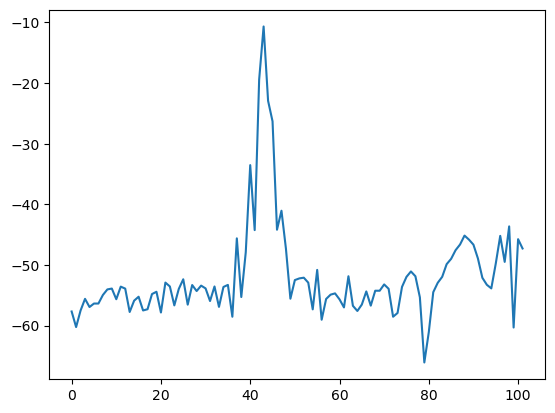

'+1.00000000000E-001\n'

['+7.68147900000E-004',
 '-1.05043200000E-003',
 '+5.30028500000E-004',
 '-7.54989700000E-004',
 '-1.06744800000E-003',
 '-7.99614400000E-004',
 '-1.63114100000E-003',
 '+5.18653100000E-005',
 '-7.69450100000E-004',
 '+1.16828300000E-003',
 '+6.40999800000E-004',
 '+1.37053800000E-003',
 '+1.04961100000E-003',
 '+1.10874000000E-003',
 '+1.71527500000E-003',
 '-2.93105300000E-004',
 '+9.29208900000E-004',
 '-1.74072900000E-003',
 '-1.80605200000E-004',
 '-1.96793900000E-003',
 '-1.50037700000E-003',
 '-6.81913500000E-004',
 '-1.87206200000E-003',
 '+8.86731400000E-004',
 '-3.05774400000E-004',
 '+2.08853600000E-003',
 '+4.91644300000E-004',
 '+1.16591500000E-003',
 '+1.61454000000E-003',
 '+2.77068200000E-004',
 '+1.63699300000E-003',
 '-5.50175000000E-004',
 '+8.15351100000E-004',
 '-1.05857600000E-003',
 '-2.39138500000E-004',
 '-1.33134900000E-003',
 '-1.43896700000E-003',
 '-1.11670900000E-003',
 '-1.91300000000E-003',
 '-1.87426300000E-004',
 '-3.35293500000E-004',
 '+1.24173800000

[-0.93939151 -0.95870651 -2.49867433  3.10980641  2.1532048   1.13332146
  0.81278676 -0.16924481 -1.08047228 -1.66231375 -2.71500717  2.69923362
  1.71616961  1.17174019  0.16995271 -0.32422841 -0.9144708  -1.74852233
 -2.48162751 -3.04392929  1.83452636  1.55139432  0.65551938 -0.69895414
 -0.85512329 -1.80783375 -2.34563027  2.64738316  2.12331587  1.6164143
 -0.38246987  0.11113859 -0.93016794 -2.95282584 -2.6067964   1.97216436
 -2.59654363  0.02045313 -1.99238331 -0.27587236  3.09065514 -0.72864748
  2.03177136  2.72792442  2.59821826 -0.18216876  1.67632115 -1.8591166
  1.60966499  3.069911    0.05293705 -2.2063048  -1.23220346  2.85034194
  1.9385513   1.61317204  0.52550134 -0.11730821 -1.1312022  -1.22661227
 -2.46855412 -3.09236148  2.34544406  1.59614513  0.90376655  0.12149524
 -0.55726073 -1.22033839 -1.9413609   3.13856811  2.34134511  1.24922996
  0.23230443  0.1000888  -0.31513805 -0.833355   -1.32755159 -1.83977927
 -2.42370612 -3.09704422  0.81869194 -0.15088262 -1.3

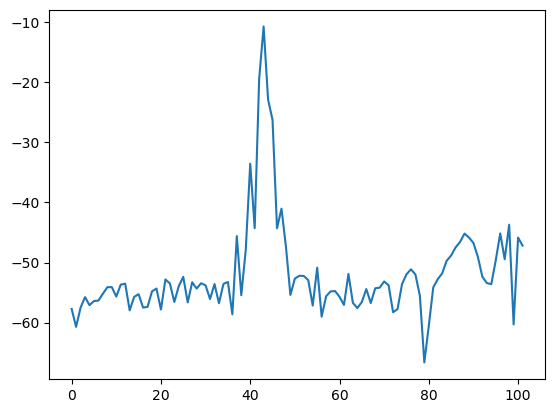

In [143]:
SendAna("CALC1:PAR:SEL 'MyMeas1'")
SendAna("FORM:BORD 'ASCII'")
netana.write("CALC1:DATA:CUST 'result'")
netana.read("CALC1:DATA:CUST? 'result'")

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [12]:
netana.query("CALC1:DATA?")#これが意味わからん

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [114]:
SendAna("FORM:BORD 'ASCII'")
netana.query("FORM:BORD?")

'NORM\n'

In [53]:
netana.query("SOUR1:POW1?")


'+0.00000000000E+000\n'

In [127]:
netana.query("CALC1:PAR:CAT?")

'"MyMeas1,S21"\n'

In [ ]:

#電源の電圧を計測
# max_volt = ADCMT.query('MEAS:VOLT?')

# queryを使わない方法
nanovol.write(":SENSe:FUNCtion 'VOLTage:DC'")

nanovol.write(":SENS:FUNC 'VOLT'")
#keithley2182A.write("*RST")
nanovol.write(":DISPlay:ENABle ON")
nanovol.write(":SENSe:VOLTage:NPLCycles 1") # medium
nanovol.write(":SENSe:VOLTage:DFILter 0") # digital filter off
for i in range(0,5):
    nanovol.write(":READ?")
    print(float(nanovol.read()))


## Graphical plot

In [ ]:
import logging
log = logging.getLogger(__name__)
log.addHandler(logging.NullHandler())

import random
from time import sleep
from pymeasure.log import console_log
from pymeasure.display import Plotter
from pymeasure.experiment import Procedure, Results, Worker
from pymeasure.experiment import IntegerParameter, FloatParameter, Parameter



class RandomProcedure(Procedure):

    iterations = IntegerParameter('Loop Iterations')
    delay = FloatParameter('Delay Time', units='s', default=0.2)
    seed = Parameter('Random Seed', default='12345')

    DATA_COLUMNS = ['Iteration', 'Random Number']

    def startup(self):
        log.info("Setting the seed of the random number generator")
        random.seed(self.seed)

    def execute(self):
        log.info("Starting the loop of %d iterations" % self.iterations)
        for i in range(self.iterations):
            data = {
                'Iteration': i,
                'Random Number': random.random()
            }
            self.emit('results', data)
            log.debug("Emitting results: %s" % data)
            self.emit('progress', 100 * i / self.iterations)
            sleep(self.delay)
            if self.should_stop():
                log.warning("Caught the stop flag in the procedure")
                break


if __name__ == "__main__":
    console_log(log)

    log.info("Constructing a RandomProcedure")
    procedure = RandomProcedure()
    procedure.iterations = 100

    data_filename = 'random.csv'
    log.info("Constructing the Results with a data file: %s" % data_filename)
    results = Results(procedure, data_filename)

    log.info("Constructing the Plotter")
    plotter = Plotter(results)
    plotter.start()
    log.info("Started the Plotter")

    log.info("Constructing the Worker")
    worker = Worker(results)
    worker.start()
    log.info("Started the Worker")

    log.info("Joining with the worker in at most 1 hr")
    worker.join(timeout=3600) # wait at most 1 hr (3600 sec)
    log.info("Finished the measurement")

In [2]:
import logging
log = logging.getLogger(__name__)
log.addHandler(logging.NullHandler())

import sys
import tempfile
import random
from time import sleep
from pymeasure.log import console_log
from pymeasure.display.Qt import QtWidgets
from pymeasure.display.windows import ManagedWindow
from pymeasure.experiment import Procedure, Results
from pymeasure.experiment import IntegerParameter, FloatParameter, Parameter

from pymeasure.instruments.keithley import Keithley2000


class RandomProcedure(Procedure):

    iterations = IntegerParameter('Loop Iterations')
    delay = FloatParameter('Delay Time', units='s', default=0.2)
    seed = Parameter('Random Seed', default='12345')

    DATA_COLUMNS = ['Iteration', 'Random Number']

    def startup(self):
        log.info("Setting the seed of the random number generator")
        random.seed(self.seed)

    def execute(self):
        log.info("Starting the loop of %d iterations" % self.iterations)
        for i in range(self.iterations):
            data = {
                'Iteration': i,
                'Random Number': random.random()
            }
            self.emit('results', data)
            log.debug("Emitting results: %s" % data)
            self.emit('progress', 100 * i / self.iterations)
            sleep(self.delay)
            if self.should_stop():
                log.warning("Caught the stop flag in the procedure")
                break
class MultimeterProcedure(Procedure):

    iterations = IntegerParameter('Loop Iterations')
    delay = FloatParameter('Delay Time', units='s', default=0.2)
    # seed = Parameter('Random Seed', default='12345')

    DATA_COLUMNS = ['Iteration', 'Voltage']

    def startup(self):
        # Set conditions here
        log.info("Setting the multimeter")
        multimeter.measure_voltage()

    def execute(self):
        # Put the runnning codes here
        log.info("Starting the loop of %d iterations" % self.iterations)
        for i in range(self.iterations):
            data = {
                'Iteration': i,
                'Voltage': multimeter.voltage
            }
            self.emit('results', data)
            log.debug("Emitting results: %s" % data)
            self.emit('progress', 100 * i / self.iterations)
            sleep(self.delay)
            if self.should_stop():
                log.warning("Caught the stop flag in the procedure")
                break

class MainWindow(ManagedWindow):

    def __init__(self):
        super().__init__(
            procedure_class=MultimeterProcedure,
            inputs=['iterations', 'delay'],
            displays=['iterations', 'delay'],
            x_axis='Iteration',
            y_axis='Voltage'
        )
        self.setWindowTitle('GUI Example')

    def queue(self):
        filename = tempfile.mktemp()

        procedure = self.make_procedure()
        results = Results(procedure, filename)
        experiment = self.new_experiment(results)

        self.manager.queue(experiment)


if __name__ == "__main__":
    multimeter = Keithley2000("GPIB::14")
    app = QtWidgets.QApplication(sys.argv)
    window = MainWindow()
    window.show()
    sys.exit(app.exec())

: 

: 